In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

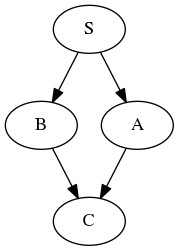

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
def create_design_matrix(times, bins, n):
    result = [np.histogram(times, bins=bins)[0]]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)


def IV(pre, post, stim_times, stop_time, sigma=1, refractory=3, latency=4, winsize=4):

    bins = np.arange(0, stop_time + sigma, sigma)
    
    pre_binary_design = create_design_matrix(
        pre, bins, int(refractory / sigma) + 1)
    pre_binary = pre_binary_design[0]
    pre_design = pre_binary_design[1:]
    
    stim_mask = create_design_matrix(
        stim_times, bins, int((latency + winsize) / sigma) + 1).sum(axis=0).astype(bool)
    
    post_binary, _ = np.histogram(post, bins=bins)
    
    X_pre_design = sm.add_constant(pre_design.T)
    model = sm.OLS(pre_binary, X_pre_design)
    
    pre_model = model.fit()
    
    cov = np.cov(
        pre_model.fittedvalues[stim_mask], 
        post_binary[stim_mask])[0,1]
    beta_IV = cov / np.var(pre_model.fittedvalues[stim_mask])
    return beta_IV

In [5]:

data = simulate(par, stim_N=10000, J_AC=0.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
stop_time = data['status']['time']
A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
stim_times = data['epoch']['times']

beta_AC = IV(A_spikes, C_spikes, stim_times, stop_time)
beta_BC = IV(B_spikes, C_spikes, stim_times, stop_time)

time_shift = 15

beta_ACr = IV(A_spikes, C_spikes, stim_times - time_shift, stop_time)
beta_BCr = IV(B_spikes, C_spikes, stim_times - time_shift, stop_time)

beta_AC_corrected = beta_AC - beta_ACr
beta_BC_corrected = beta_BC - beta_BCr


simulating  425472.0
stimulating  10000


In [7]:
beta_BC, beta_AC

(0.03967038802283302, 0.02606791871139339)